In [8]:
import healpy as hp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import os
import matplotlib.pyplot as plt
from astropy.io import fits
tf.keras.backend.clear_session() #clear any previous models

data_directory = "/mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/SkySimulation/data/simulated_data/"
os.chdir(data_directory)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #disable GPU
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  #suppress TF warnings
print("Current working directory:", os.getcwd())

Current working directory: /mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/SkySimulation/data/simulated_data


In [9]:
import tensorflow as tf, sys, os
print("TF:", tf.__version__)
print("Python:", sys.version.split()[0])
print("LD_LIBRARY_PATH:", os.environ.get("LD_LIBRARY_PATH"))

TF: 2.10.1
Python: 3.10.15
LD_LIBRARY_PATH: /opt/cesga/system/software/Core/tensorflow/2.10.1-gpu-conda/lib:/opt/cesga/system/software/Core/tensorflow/2.10.1-gpu-conda/lib/python3.10/site-packages/nvidia/cudnn/lib:/opt/cesga/system/software/Core/tensorflow/2.10.1-gpu-conda/lib/python3.10/site-packages/nvidia/cublas/lib:/opt/cesga/system/software/Core/tensorflow/2.10.1-gpu-conda/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/opt/cesga/system/software/Core/tensorflow/2.10.1-gpu-conda/lib/python3.10/site-packages/tensorrt:/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/gr/lib64


Filename: ./simulated_maps/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   768R x 1C   [1024D]   


ColDefs(
    name = 'T'; format = '1024D'
)
NSIDE: 256


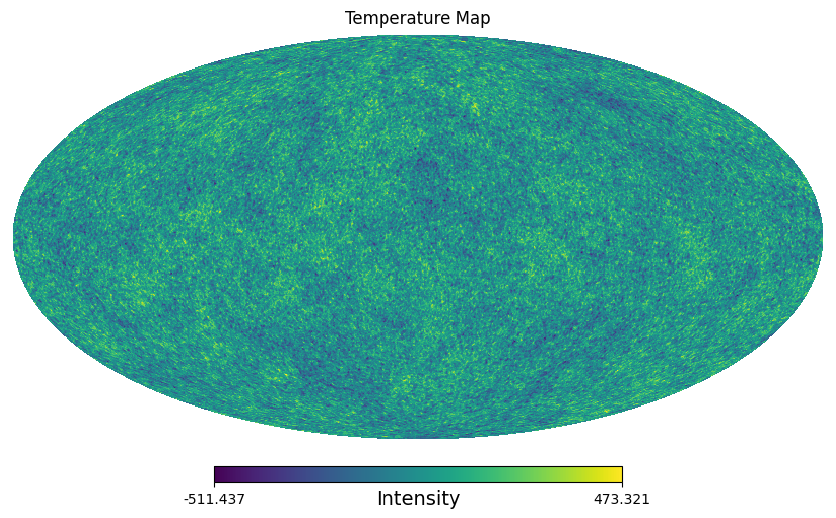

In [10]:
from SkyNeuralNets import read_map
#Read the data
path_lcdm = "./simulated_maps/"
map_temp_data = read_map(path_lcdm + 'cmb_map_0.fits')

#Visualize the map
nside = hp.npix2nside(len(map_temp_data))
#nside = 64
print(f"NSIDE: {nside}")

#Plot
hp.mollview(map_temp_data, title="Temperature Map", unit="Intensity")
plt.show()

In [11]:
def read_all_maps(path_lcdm, path_feature, n_maps=100):
    maps = []
    labels = []
    
    #LCDM maps
    for i in range(n_maps):
        map_lcdm = read_map(f"{path_lcdm}cmb_map_{i}.fits")
        maps.append(map_lcdm)
        labels.append(0)  #lcdm
    
    #Feature maps
    for i in range(n_maps):
        map_feature = read_map(f"{path_feature}cmb_map_feature_{i}.fits")
        maps.append(map_feature)
        labels.append(1)  #feature
    
    maps = np.array(maps).astype(np.float32)[..., None]  #Add channel dimension
    labels = np.array(labels).astype(np.int32)
    #print(labels)
    return maps, labels

In [12]:
def map_to_image(hp_map, xsize=256):
    #Validate that map has correct length
    hp_map = np.asarray(hp_map, dtype=np.float64)
    try:
        nside = hp.get_nside(hp_map)
    except Exception as e:
        print("Invalid map shape:", hp_map.shape)
        raise e
    img = hp.cartview(hp_map, xsize=xsize, return_projected_map=True, title="", cbar=False)
    plt.close()
    return img

In [13]:
path_feature = "./simulated_maps/"
x_raw, y_raw = read_all_maps(path_lcdm, path_feature, n_maps=225) #0: lcdm, 1:feature

Filename: ./simulated_maps/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   768R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/cmb_map_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   768R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/cmb_map_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   768R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/cmb_map_3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   768R x 1C  

In [14]:
x_raw_new = np.array(x_raw).squeeze()

In [15]:
imgs = np.array([map_to_image(m) for m in x_raw_new])
if imgs.ndim == 3:
    imgs = imgs[..., np.newaxis]  #add channel dimension

In [16]:
# Compare two HEALPix maps on the sphere

# 1) Mollweide full-sky view
def compare_maps_spherical(A, B, titleA="Map A", titleB="Map B", unit="μK", 
                            lon_center=0, lat_center=0, patch_size=800, patch_reso=5):
    """
    Compare two HEALPix maps on the sphere:
    - Mollweide projection for both maps and their difference
    - Zoomed gnomonic patches
    - Angular power spectra
    """
    #common scale for fair visual comparison
    vmin = np.percentile(np.concatenate([A, B]), 0.5)
    vmax = np.percentile(np.concatenate([A, B]), 99.5)
    diff = B - A

    plt.figure(figsize=(12,4))
    hp.mollview(A, title=titleA, unit=unit, min=vmin, max=vmax, cmap="coolwarm", sub=(1,3,1))
    hp.mollview(B, title=titleB, unit=unit, min=vmin, max=vmax, cmap="coolwarm", sub=(1,3,2))
    hp.mollview(diff, title=f"{titleB} - {titleA}", unit=unit, cmap="coolwarm", sub=(1,3,3))
    plt.tight_layout()


### 2) Zoomed gnomonic patches

def compare_maps_patches(A, B, titleA="Map A", titleB="Map B", 
                      lon_center=0, lat_center=0, patch_size=800, patch_reso=5):
    """ Compare two HEALPix maps in zoomed patches:
    - Gnomonic projections for both maps and their difference
    - Angular power spectra (commented out)
    """
    #common scale for fair visual comparison
    vmin = np.percentile(np.concatenate([A, B]), 0.5)
    vmax = np.percentile(np.concatenate([A, B]), 99.5)
    diff = B - A

    plt.figure(figsize=(12,4))
    hp.gnomview(A, rot=(lon_center, lat_center), xsize=patch_size, reso=patch_reso, 
                title=f"{titleA} patch", cmap="coolwarm", min=vmin, max=vmax, sub=(1,3,1))
    hp.gnomview(B, rot=(lon_center, lat_center), xsize=patch_size, reso=patch_reso, 
                title=f"{titleB} patch", cmap="coolwarm", min=vmin, max=vmax, sub=(1,3,2))
    hp.gnomview(diff, rot=(lon_center, lat_center), xsize=patch_size, reso=patch_reso, 
                title="Difference patch", cmap="coolwarm", sub=(1,3,3))
    plt.tight_layout()


/home/csic/eoy/ioj/.local/lib/python3.10/site-packages/functions/data_preprocessing.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


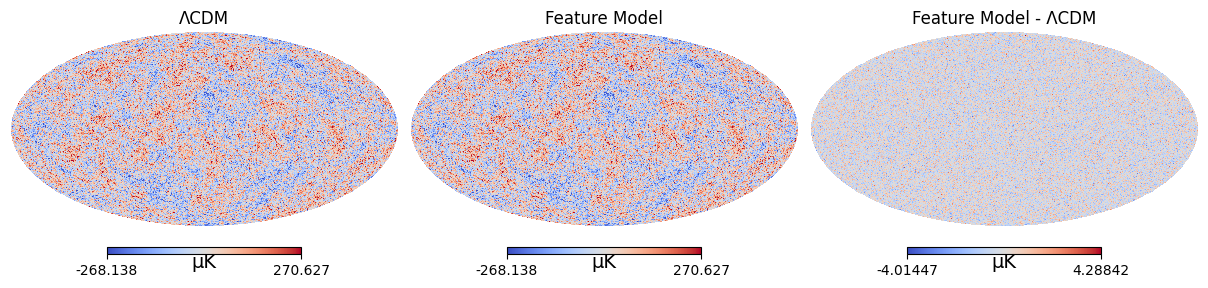

In [17]:
from SkyNeuralNets import compare_maps_spherical, compare_maps_patches
compare_maps_spherical(x_raw_new[0], x_raw_new[225], titleA="ΛCDM", titleB="Feature Model", lon_center=0, lat_center=0)
#plt.savefig("/mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/SkyNeuralNets/plots/comparison_maps.png", dpi=300)

/home/csic/eoy/ioj/.local/lib/python3.10/site-packages/functions/data_preprocessing.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


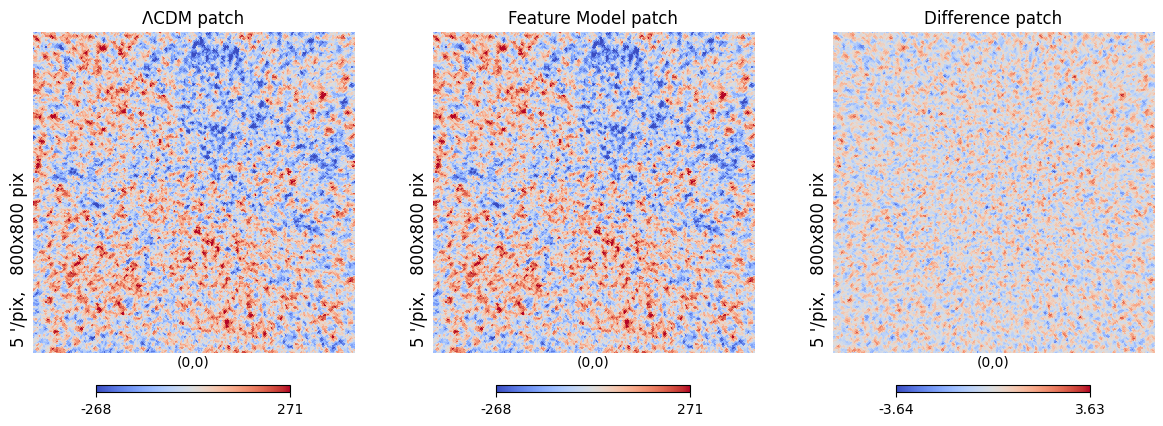

In [18]:
compare_maps_patches(x_raw_new[0], x_raw_new[225], titleA="ΛCDM", titleB="Feature Model", lon_center=0, lat_center=0)
#plt.savefig("/mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/SkyNeuralNets/plots/comparison_patches.png", dpi=300)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs, y_raw, test_size=0.2, random_state=15)
X_test, X_val, y_test, y_val = train_test_split(imgs, y_raw, test_size=0.2, random_state=15)

In [20]:
def z_score_norm(X_train, X_test, X_val):

    """Compute μ,σ on TRAIN ONLY; apply to all splits. Returns scaled arrays + (μ,σ)."""
    mu  = X_train.mean(dtype=np.float64)
    std = X_train.std(dtype=np.float64)
    # avoid divide-by-zero
    std = std if std > 0 else 1.0

    def _scale(Z): return ((Z - mu) / std).astype(np.float32)
    return _scale(X_train), _scale(X_test),  _scale(X_val), (float(mu), float(std))

In [21]:
from SkyNeuralNets import z_score_norm
X_train, X_test, X_val, (mu, std) = z_score_norm(X_train, X_test, X_val)

In [22]:
#======== Define Model ========
model = models.Sequential([
    layers.Input(shape=imgs.shape[1:]),        

    layers.Conv2D(32, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(), layers.ReLU(),

    layers.GlobalAveragePooling2D(),             
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu",
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)
model.summary(110)

Model: "sequential"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 conv2d (Conv2D)                                 (None, 128, 256, 32)                        288              
                                                                                                              
 batch_normalization (BatchNormalization)        (None, 128, 256, 32)                        128              
                                                                                                              
 re_lu (ReLU)                                    (None, 128, 256, 32)                        0                
                                                                                                              
 max_pooling2d (MaxPooling2D)                    (None, 64, 128, 32)                        

In [24]:
cb = [
  tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=150, mode="max", restore_best_weights=True),
  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=4, mode="max", min_lr=1e-6)
]

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), callbacks=cb)

Epoch 1/500
12/12 [==============================] - 10s 703ms/step - loss: 0.7215 - accuracy: 0.4889 - auc: 0.4973 - val_loss: 0.7004 - val_accuracy: 0.5444 - val_auc: 0.5000 - lr: 1.0000e-04
Epoch 2/500
12/12 [==============================] - 8s 600ms/step - loss: 0.6981 - accuracy: 0.5556 - auc: 0.5658 - val_loss: 0.6983 - val_accuracy: 0.5444 - val_auc: 0.4706 - lr: 1.0000e-04
Epoch 3/500
12/12 [==============================] - 7s 592ms/step - loss: 0.7222 - accuracy: 0.5139 - auc: 0.5033 - val_loss: 0.6992 - val_accuracy: 0.5444 - val_auc: 0.4993 - lr: 1.0000e-04
Epoch 4/500
12/12 [==============================] - 7s 556ms/step - loss: 0.7148 - accuracy: 0.5083 - auc: 0.5050 - val_loss: 0.7001 - val_accuracy: 0.5444 - val_auc: 0.4699 - lr: 1.0000e-04
Epoch 5/500
12/12 [==============================] - 6s 529ms/step - loss: 0.7357 - accuracy: 0.4861 - auc: 0.4662 - val_loss: 0.7068 - val_accuracy: 0.4556 - val_auc: 0.4978 - lr: 1.0000e-04
Epoch 6/500
12/12 [====================

In [25]:
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

12/12 [==============================] - 1s 92ms/step - loss: 0.7021 - accuracy: 0.4889 - auc: 0.5000
Test accuracy: 0.4889


Text(0, 0.5, 'Accuracy')

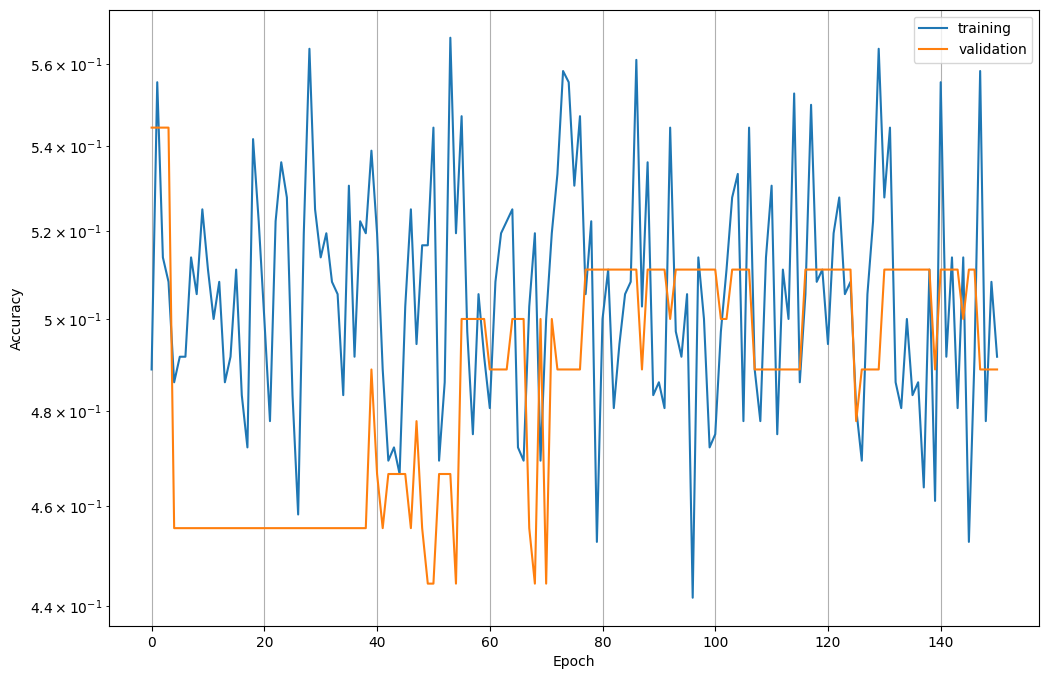

In [26]:
plt.figure(figsize=(12,8))
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

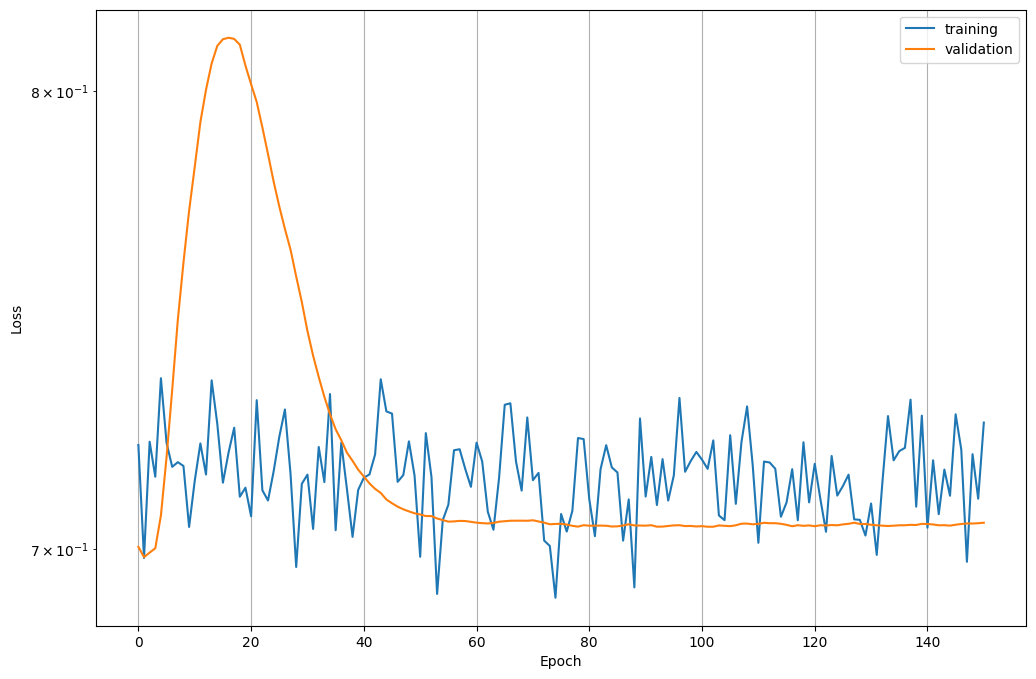

In [27]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [28]:
#sanity check
print(np.mean(X_train), np.std(X_train))   #mean~0, st.dev~1
print(np.mean(X_test),  np.std(X_test))    #should be close to train

2.0696058e-11 0.9999997
2.0696058e-11 0.9999997


In [29]:
# Get model probabilities
probs = model.predict(X_test, batch_size=64).ravel()

6/6 [==============================] - 1s 183ms/step


In [30]:
#Check the class balance, do we have a 50/50 split?
print("class balance test:", (y_test==1).mean())

class balance test: 0.4888888888888889


In [31]:
#Let's check the ranges of probabilities, why is the CNN classfiying everything as LCDM?
print("min/max/mean probs:", probs.min(), probs.max(), probs.mean())

min/max/mean probs: 0.5075739 0.5077871 0.5076667


In [32]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

#Find optimal threshold from ROC
fpr, tpr, thr = roc_curve(y_test, probs)
t_opt = thr[np.argmax(tpr - fpr)]
print("AUC:", auc(fpr, tpr), "t*:", t_opt)

#Apply the new threshold to get predictions, Youden's index https://en.wikipedia.org/wiki/Youden%27s_J_statistic
pred = (probs >= t_opt).astype(int)

#Accuracy
acc = accuracy_score(y_test, pred)
print("Accuracy:", acc)

#Confusion matrix
cm = confusion_matrix(y_test, pred, labels=[0, 1])
print("Confusion matrix:\n", cm)


AUC: 0.47785943675889325 t*: 0.5075805
Accuracy: 0.5333333333333333
Confusion matrix:
 [[ 16 168]
 [  0 176]]


In [33]:
#-----------------------------------------------------------------------------------------------------------
#Performance: correct & incorrect  predictions
#-----------------------------------------------------------------------------------------------------------
#True positive: LCDM=0, Feature=1
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []

for pred, true in zip(pred, y_test):
    if pred==0 and true==0:
        true_LCDM.append(1)
    if pred==1 and true==1:
        true_MoG.append(1)
    if pred==0 and true==1:
        false_LCDM.append(1)
    if pred==1 and true==0:
        false_MoG.append(1)
lenghts=[len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]

print('     ','LCDM','FT')
print('True ',len(true_LCDM)/sum(lenghts),len(true_MoG)/sum(lenghts))
print('False',len(false_LCDM)/sum(lenghts),len(false_MoG)/sum(lenghts))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lenghts))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lenghts))

      LCDM FT
True  0.044444444444444446 0.4888888888888889
False 0.0 0.4666666666666667
--------------
Correct prediction:  0.5333333333333333
Wrong prediction  :  0.4666666666666667


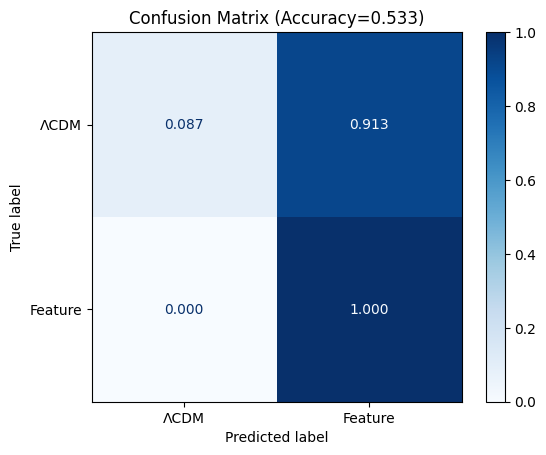

In [34]:
#Plot confusion matrix
cm_prob = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_prob, display_labels=["ΛCDM", "Feature"])
disp.plot(cmap="Blues", values_format='.3f')
plt.title(f"Confusion Matrix (Accuracy={acc:.3f})")
#plt.savefig("/mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/SkyNeuralNets/plots/confusion_matrix.png", dpi=300)
plt.show()

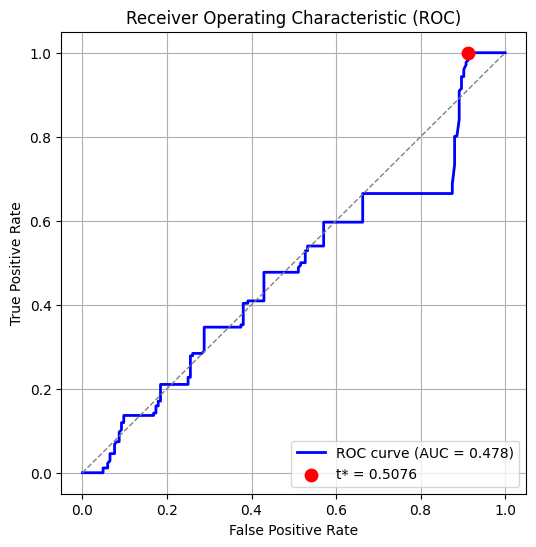

In [35]:
#Plot the ROC curve with Youden index (https://en.wikipedia.org/wiki/Youden%27s_J_statistic#/media/File:ROC_Curve_T1D_Validation,_top5_r2filtered.svg)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")

t_star_idx = np.argmax(tpr - fpr)
t_star = thr[t_star_idx]

#Mark t* point
plt.scatter(fpr[t_star_idx], tpr[t_star_idx], color="red", s=80, zorder=5,
            label=f"t* = {t_star:.4f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()